# Lane Detection - Computer Vision


Omar Mohamed Lotfy 18p5606 <br>
Nour El-din Mohamed 18p5806

## Importing Libraries

In [40]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Change according to desired files

In [41]:
testimage='test_images/test2.jpg'
cameracal='camera_cal/calibration2.jpg'
inputvideo= 'project_video_short.mp4'
outputvideo= 'Team_vision.mp4'

## Reading image and displaying its size

Image size is: (1280, 720)


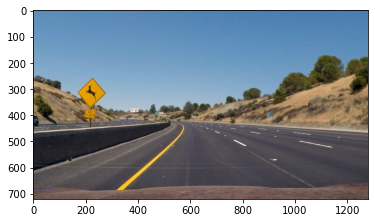

In [42]:
# Read image and plot Test 2 image
image=mpimg.imread(testimage)
plt.imshow(image)

#Save Image size
image_size = (image.shape[1], image.shape[0])
print("Image size is:",image_size)

## Camera Calibration

Text(0.5, 1.0, 'Undistorted Image')

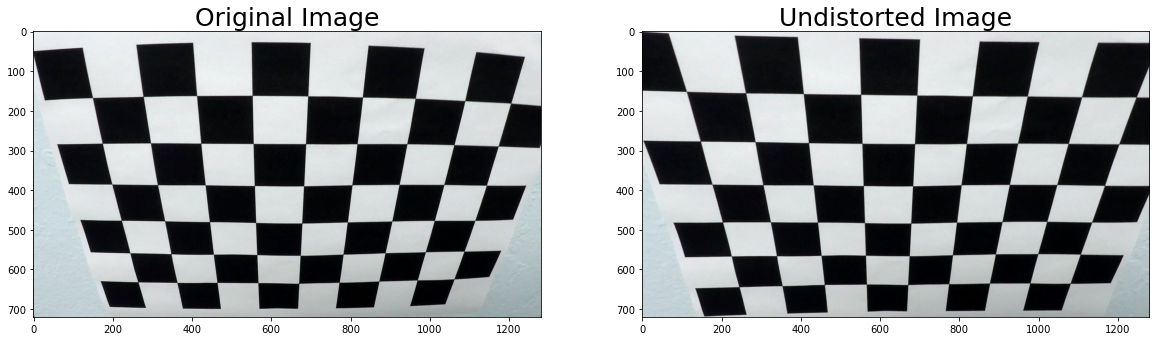

In [43]:
# Initialize object points in array of shape (54(size of chessboard), 3)
objp = np.zeros((6*9,3), np.float32)

#(putting indices for the chessboard Ex: (0,0),(0,1) ....(8,5))
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

## Arrays to store object points and image points from all the images.
O_points = [] # array to store object points EX:(0,0,0)
I_points = [] # array to store Image points EX:(6,2)

# find all files that its name starts with calibration and of type jpg then put them in a list
Calibration_Images = glob.glob('camera_cal/calibration*.jpg')


# Search For chessborad Corners In the list containing calibrated images
for FileName in Calibration_Images:
    img = cv2.imread (FileName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Turning Image into gray scale
    
    # Find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if found == True:
        O_points.append(objp)
        I_points.append(corners)        

# Test undistortion on a chess image
img = cv2.imread(cameracal)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(O_points, I_points, img_size,None,None)

# Applying the undistort to an image based on the calibration 
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion on chessboard

figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(20,12))
axis_1.imshow(img)
axis_1.set_title('Original Image', fontsize=25)
axis_2.imshow(dst)
axis_2.set_title('Undistorted Image', fontsize=25)

## View undistorted image of Lane

Text(0.5, 1.0, 'Undistorted Image')

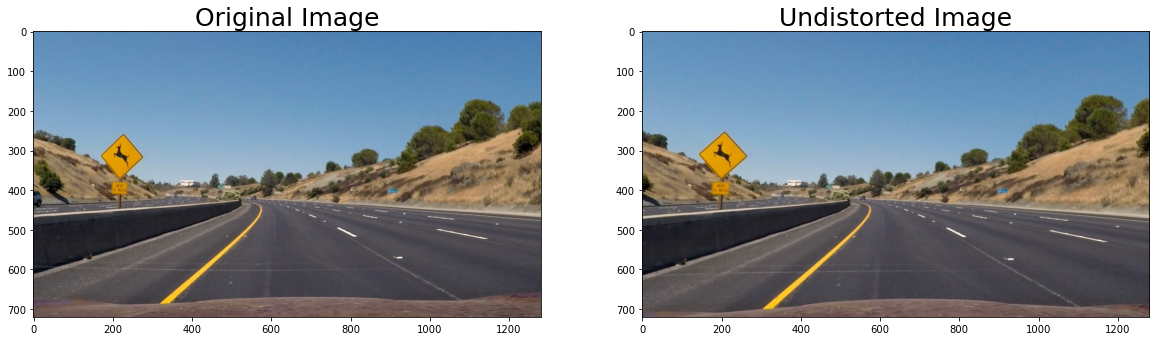

In [44]:
# undistort On test 2 image using mtx and dist generated from chessboard camera calibration
undist_img = cv2.undistort(image,mtx,dist,None,mtx)

# visualize undistortion on test 2 image
figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(20,12))
axis_1.imshow(image)
axis_1.set_title('Original Image', fontsize=25)
axis_2.imshow(undist_img)
axis_2.set_title('Undistorted Image', fontsize=25)

## Thresholding

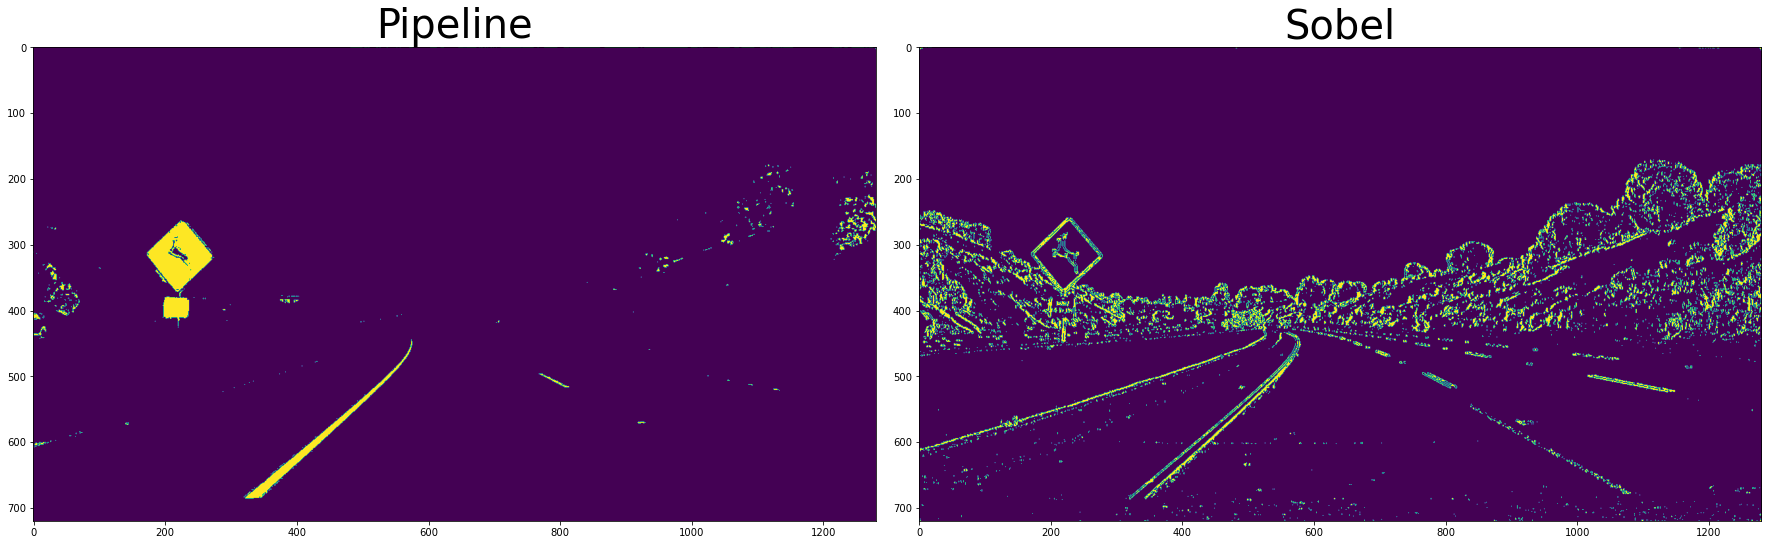

In [45]:
def thresholding(img):
    
    img = np.copy(img)
    s_thresh=(170, 255) 
    sx_thresh=(20, 100)
    
    # Apply color threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    #Apply sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >=sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return s_binary, sxbinary, combined_binary

pip, sobel, com = thresholding(image)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#
ax1.imshow(pip)
ax1.set_title('Pipeline', fontsize=40)
#
ax2.imshow(sobel)
ax2.set_title('Sobel', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



Text(0.5, 1.0, 'Combined')

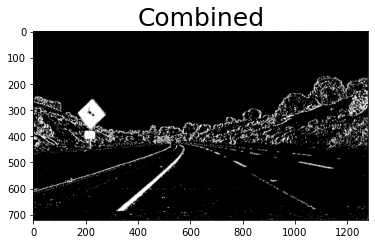

In [47]:
plt.imshow(com,cmap='gray')
plt.title("Combined",fontsize=25)

## Prespective
We change the view of the lane into birdseye view

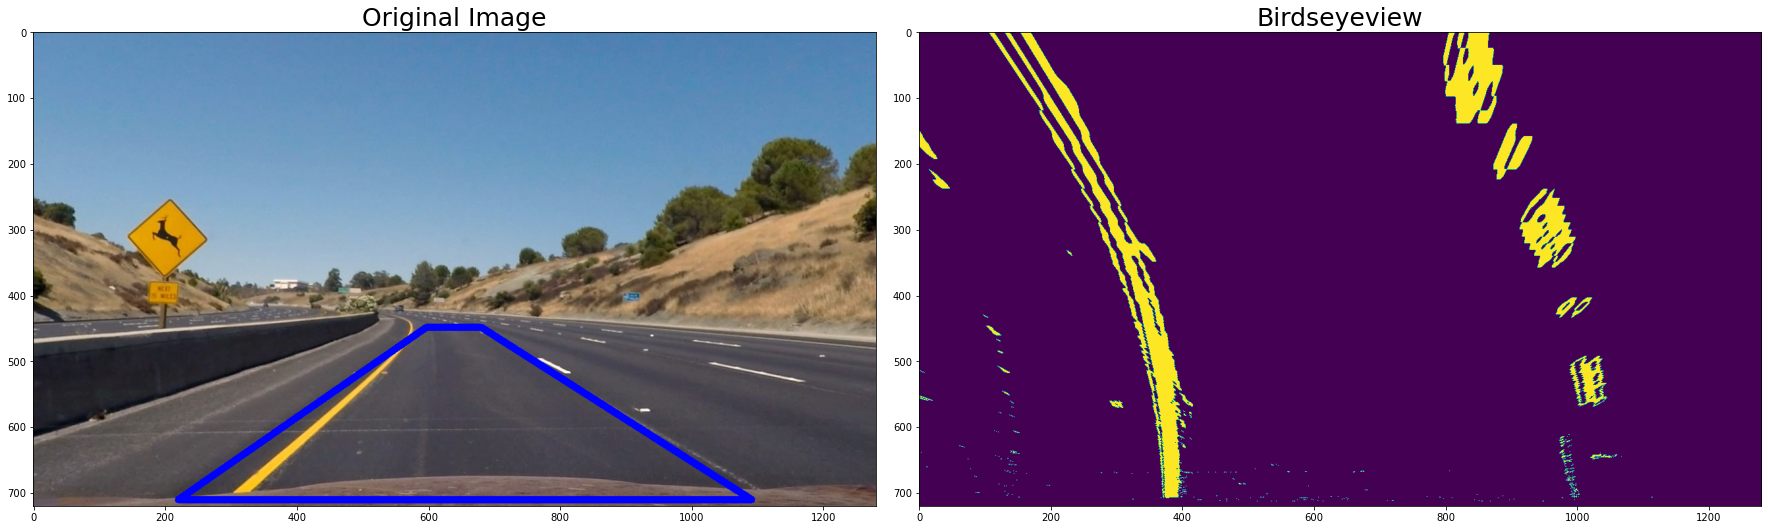

In [28]:
# define source coordinates
src= np.float32(
        [[220,710],
         [597,448],
         [680,448],
        [1091,710]])

#define destination coordinates 
dst= np.float32(
        [[320,710],
        [320,10],
        [970,10] ,
        [970,710]])  

# Perspective transform for birdseye
def perspective(img,src,dst):
    M= cv2.getPerspectiveTransform(src,dst)
    Minv= cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags =  cv2.INTER_LINEAR)
    return warped, M, Minv

#Test 2 image after thresholding showing it in birdseye view
image = cv2.undistort(image,mtx,dist,None,mtx)
pip, sobel, com  = thresholding(image)
#    warped_im, transf =perspect(bird,src,dst)
binary_warped, M, Minv= perspective(com,src,dst)

vertices = np.array([[220,710],[597,448],[680,448],[1091,710]], np.int32)
vertices = vertices.reshape((-1,1,2))
bird = cv2.polylines(image, [vertices], True, (0,0,255),10)

# Plot image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bird)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(binary_warped)
ax2.set_title('Birdseyeview', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining all above steps in one Function 
1. Undistort image
2. Make thresholding
3. Get Birdseye view prespective

In [29]:
def imagepro(img):
    image = cv2.undistort(img,mtx,dist,None,mtx)
    pip, sobel, com = thresholding(image)
    binary_warped, M, Minv= perspective(com,src,dst)
    
    return image, binary_warped, Minv

## Find lane Lines
By Sliding window method

In [30]:
# Function to apply the sliding window algorithm for the first time to find the lane lines
# It takes the processed image as an input and ouputs the fit coefficients and the lane pixels
def findlanefirst(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit= None
    right_fit= None
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

## function to plot lane for first Time 

[-5.10526460e-04  7.09018576e-01  1.35566016e+02] [-3.87389199e-04  5.88839578e-01  8.06482799e+02]


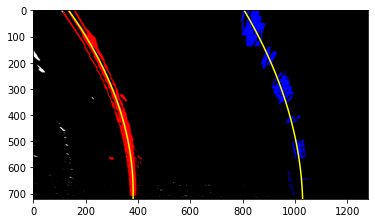

In [31]:
# Function to plot the lane lines as the result of findlanefirst().  
#It takes in the lane pixels and fit the second degree curve.
# The fitted curve is shown in yellow.

def plot_full_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):    
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Sample Y vaules to generate the x values by the fitted curve equation
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Left lane pixels in red and right lane pixels in blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

img = cv2.imread(testimage)
image, binary_warped, Minv = imagepro(img)
left_fit, right_fit, left_lane_inds, right_lane_inds= findlanefirst(binary_warped)
print(left_fit, right_fit)
plot_full_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)


## Continue Finding Lanes

In [32]:
# function to find the lane once you already have your first fits using findlanefirst()
def find_lane(binary_warped, left_fit, right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit= None
    right_fit= None
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

## Plot lane
with margin birdseye view

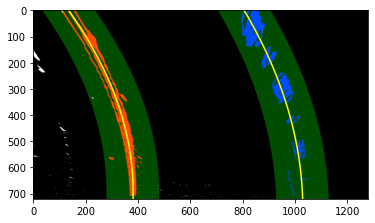

In [34]:
def plot_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds): 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    margin = 100
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

## Measure Curvature

In [35]:
def curv_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = binary_warped.shape[0]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
       
    if len(leftx) != 0 and len(rightx) != 0:
    #print (1/np.absolute(2*right_fit_cr[0]))
    # Calculate the new radii of curvature
     # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Finding the position of car based on the assumtion that the camera is mounted on the center of the vehicle
    if right_fit is not None and left_fit is not None:
        car_px = binary_warped.shape[1]/2
        l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        
        lane_center = (l+r) /2
        
        # Changing it to world coordinates
        center_dist = (car_px - lane_center) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

left_curverad, right_curverad, center_dist= curv_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

## Plot Lane After detection
with normal view

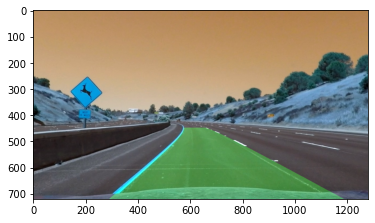

In [36]:
def plotback(binary_warped, image, left_fit, right_fit, Minv):

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

result= plotback(binary_warped, image, left_fit, right_fit, Minv)
plt.imshow(result)

## Draw Data on Frame

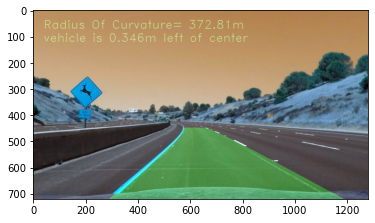

In [37]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius Of Curvature= ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155))
    direction = ''
    # positive center distance right and negative center distance left
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'vehicle is '+'{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155))
    return new_img
curv_rad = (abs(left_curverad)+abs(right_curverad))/2
new_img = draw_data(result, curv_rad, center_dist)
plt.imshow(new_img)

## Class line 
to detect which state is the line at and depending on that which function it'll call

In [38]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Counter for number
        self.linenum=0
    
    # Function to take in the current fit to produce an average fit from the previous 5 fits
    def add_fit(self, fit, ind):
        if self.linenum > 15:
            if fit is not None:
                self.detected= True
                self.current_fit.append(fit)
                if len(self.current_fit)>15:
                    self.current_fit= self.current_fit[len(self.current_fit)-15:]
                self.best_fit = np.average (self.current_fit, axis=0)

            else:
                self.detected = False
                if len(self.current_fit)>0:
                    self.best_fit= np.average(self.current_fit, axis=0)
        else:
            if fit is not None:
                self.detected= True
                self.current_fit.append(fit)
                if len(self.current_fit)>1:
                    self.current_fit= self.current_fit[len(self.current_fit)-1:]
                self.best_fit = np.average (self.current_fit, axis=0)

            else:
                self.detected = False
                if len(self.current_fit)>0:
                    self.best_fit= np.average(self.current_fit, axis=0)

## Function To process Frames
1. wraping image in birdseyeprespective
2. if first lane detection call finlanefirst() to apply sliding window else call findlane()
3. call curv_dist() to get curvature and distance 
4. calculate lane size
5. call function add_fit() in lane class
6. if lane detected draw lane else return original frame

In [39]:
def process_image(img):
    image1= np.copy(img)
    
    image, binary_warped, Minv= imagepro(image1)
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds= findlanefirst(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds= find_lane(binary_warped, left_line.best_fit, right_line.best_fit)
        
    #Checking for curvature and distance
    
    if left_fit is not None and right_fit is not None:
        
        lcurv,rcurv, dist = curv_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
        if abs(lcurv) < 100 or abs(rcurv)<100:
           left_fit= None
           right_fit= None
        
        y_eval = image.shape[0]
            
        l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        lane_size= abs(l-r)
        
        # Checking for the lane line width
        if lane_size <400 or lane_size>1000:
            left_fit = None
            right_fit=  None
            
    left_line.add_fit(left_fit,left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
        
    if left_line.best_fit is not None and right_line.best_fit is not None:
        img_out = plotback(binary_warped, image, left_line.best_fit, right_line.best_fit, Minv)
        lcurv,rcurv, dist = curv_dist(binary_warped, left_line.best_fit, right_line.best_fit,left_lane_inds, right_lane_inds)
        img_out = draw_data(img_out, (lcurv+rcurv)/2, dist)
    else:
        img_out = image
        
    left_line.linenum=left_line.linenum+1
    right_line.linenum=right_line.linenum+1
        
    return img_out

## Import video and process frames
save lane-detected video in the same folder 

In [19]:
#Create line objects
left_line= Line()
right_line= Line()



# creating a clip and applying the process_image function to every frame of the video
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image)

%time clip.write_videofile(outputvideo, audio=False)

Moviepy - Building video project_output_yarab_Omar.mp4.
Moviepy - Writing video project_output_yarab_Omar.mp4



Moviepy - Done !
Moviepy - video ready project_output_yarab_Omar.mp4
Wall time: 40.3 s
